source: scButterfly

# Perturb prediction

The following tutorial demonstrate how to use scButterfly framework making translation between the gene expressions of control and stimulated groups.

We focus on the scRNA-seq perturbation and adapt a pair of encoder and decoder seperately for control and stimulate groups. Because the perturb data is unpaired data, we follow the strategy in [unpaired data training](../RNA_ATAC_unpaired_prediction/RNA_ATAC_unpaired_scButterfly-T.ipynb).

There are three part of this tutorial:

* **Load data and data pre-processing**. This part will tell you how to load perturbation responses data to scButterfly model. 

* **Construct and train a scButterfly model**. This part will tell you how to generate and train a scButterfly model correctly.

* **Get prediction and evaluate the performance**. This part will tell you how to get prediction from scButterfly model and evaluate the performance of prediction.

In [1]:
import scanpy as sc
import pandas as pd

## Load data and data pre-processing

Here we use the human peripheral blood mononuclear cells (PBMC) stimulated with interferon (IFN-β) as example. ([Lotfollahi, M, et al., 2019](https://www.nature.com/articles/s41592-019-0494-8))

In [8]:
#sc_data = sc.read_h5ad('PT_PBMC.h5ad')

train_data = "../data/pbmc/train_pbmc.h5ad"
valid_data = "../data/pbmc/valid_pbmc.h5ad"

# pbmc data from scGen is already split into train and valid, but we will concatenate them to do a custom split
sc_data_train = sc.read_h5ad(train_data)
sc_data_valid = sc.read_h5ad(valid_data)
sc_data = sc_data_train.concatenate(sc_data_valid)

/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/g/kreshuk/katzalis/conda/miniforge3/envs/thesis/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is wher

In [9]:
sc_data

AnnData object with n_obs × n_vars = 18868 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type', 'batch'
    var: 'gene_symbol', 'n_cells'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

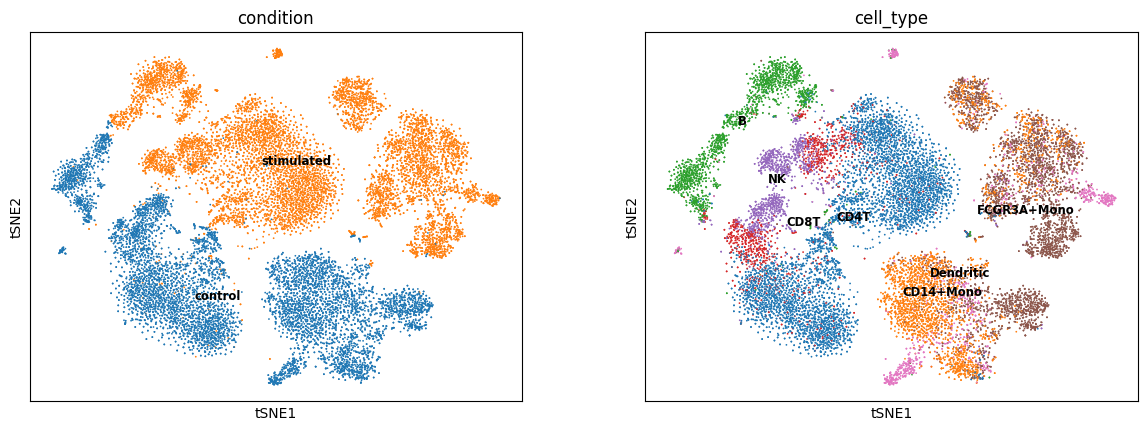

In [10]:
sc.pp.pca(sc_data)
sc.pp.neighbors(sc_data)
sc.tl.tsne(sc_data)
sc.pl.tsne(sc_data, color=['condition', 'cell_type'], legend_loc='on data', legend_fontsize='small')

In [11]:
Control_data = sc_data[sc_data.obs.condition == 'control']
Stimulate_data = sc_data[sc_data.obs.condition == 'stimulated']
Control_data.obs.index = [str(i) for i in range(Control_data.X.shape[0])]
Stimulate_data.obs.index = [str(i) for i in range(Stimulate_data.X.shape[0])]

<div class="alert note">
<p>

**Note**

We use the processed data provided in scGen([Lotfollahi, M, et al., 2019](https://www.nature.com/articles/s41592-019-0494-8)), to keep consistency for evaluation, we choose no preprocessing here. You could feel free for using other proper processing.

</p>
</div>

In [13]:
from scButterfly.split_datasets import *
id_list, id_list_dict = unpaired_split_dataset_perturb(Control_data, Stimulate_data)
train_id_r, train_id_a, validation_id_r, validation_id_a, test_id_r, test_id_a = id_list[0]

optimal transport array torch.Size([2715, 3483])
CD4T, control num 2715 stimulate num 3483

optimal transport array torch.Size([2184, 698])
CD14+Mono, control num 2184 stimulate num 698

optimal transport array torch.Size([928, 1105])
B, control num 928 stimulate num 1105

optimal transport array torch.Size([643, 594])
CD8T, control num 643 stimulate num 594

optimal transport array torch.Size([571, 733])
NK, control num 571 stimulate num 733

optimal transport array torch.Size([1232, 2790])
FCGR3A+Mono, control num 1232 stimulate num 2790

optimal transport array torch.Size([670, 522])
Dendritic, control num 670 stimulate num 522


Start CD4T
Batch list ['Dendritic', 'B', 'FCGR3A+Mono', 'CD14+Mono', 'CD4T', 'NK', 'CD8T']
Test batch control ['Dendritic']
Validation batch control ['B', 'FCGR3A+Mono', 'CD14+Mono', 'CD4T', 'NK', 'CD8T']
Train batch control ['B', 'FCGR3A+Mono', 'CD14+Mono', 'CD4T', 'NK', 'CD8T']
Test batch stimulated ['Dendritic']
Validation batch stimulated ['B', 'FCGR3A+

In [14]:
Control_data[test_id_r].obs.cell_type

index
AAACATACATTTCC-1-control-0    Dendritic
AAACATACCTGGTA-1-control-0    Dendritic
AAACGGCTCTTCGC-1-control-0    Dendritic
AAACGGCTTCTCTA-1-control-0    Dendritic
AAAGTTTGTGTGGT-1-control-0    Dendritic
                                ...    
TATACAGAGACGTT-1-control-1    Dendritic
ACCCGTTGGCTGAT-1-control-1    Dendritic
ATCACGGAACCCTC-1-control-1    Dendritic
AACTCTTGGTAGGG-1-control-1    Dendritic
AATTGATGCCACCT-1-control-1    Dendritic
Name: cell_type, Length: 670, dtype: category
Categories (1, object): ['Dendritic']

## Construct and train a scButterfly model

We could load scButterfly model for perturb from ``scButterfly.train_model_perturb``

<div class="alert warning">
<p>

**Warning**

We propose you to ensure that the settings of parameters for construct model and train model are same with here, while feel free to decide path for logging and model output.

</p>
</div>

In [15]:
from scButterfly.train_model_perturb import Model
import torch
import torch.nn as nn

In [16]:
RNA_input_dim = Control_data.X.shape[1]
ATAC_input_dim = Stimulate_data.X.shape[1]

R_kl_div = 1 / RNA_input_dim * 20
A_kl_div = 1 / ATAC_input_dim * 20
kl_div = R_kl_div + A_kl_div

In [17]:
model = Model(
    R_encoder_nlayer = 2, 
    A_encoder_nlayer = 2,
    R_decoder_nlayer = 2, 
    A_decoder_nlayer = 2,
    R_encoder_dim_list = [RNA_input_dim, 256, 128],
    A_encoder_dim_list = [ATAC_input_dim, 128, 128],
    R_decoder_dim_list = [128, 256, RNA_input_dim],
    A_decoder_dim_list = [128, 128, ATAC_input_dim],
    R_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_encoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    R_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    A_decoder_act_list = [nn.LeakyReLU(), nn.LeakyReLU()],
    translator_embed_dim = 128, 
    translator_input_dim_r = 128,
    translator_input_dim_a = 128,
    translator_embed_act_list = [nn.LeakyReLU(), nn.LeakyReLU(), nn.LeakyReLU()],
    discriminator_nlayer = 1,
    discriminator_dim_list_R = [128],
    discriminator_dim_list_A = [128],
    discriminator_act_list = [nn.Sigmoid()],
    dropout_rate = 0.1,
    R_noise_rate = 0.5,
    A_noise_rate = 0.5,
    chrom_list = [],
    logging_path = None,
    RNA_data = Control_data,
    ATAC_data = Stimulate_data,
    name="butterfly/pbmc"
)

Train a scButterfly model.

In [18]:
model.train(
    R_encoder_lr = 0.001,
    A_encoder_lr = 0.001,
    R_decoder_lr = 0.001,
    A_decoder_lr = 0.001,
    R_translator_lr = 0.001,
    A_translator_lr = 0.001,
    translator_lr = 0.001,
    discriminator_lr = 0.005,
    R2R_pretrain_epoch = 100,
    A2A_pretrain_epoch = 100,
    lock_encoder_and_decoder = False,
    translator_epoch = 200,
    patience = 50,
    batch_size = 64,
    r_loss = nn.MSELoss(size_average=True),
    a_loss = nn.MSELoss(size_average=True),
    d_loss = nn.BCELoss(size_average=True),
    loss_weight = [1, 1, 1, R_kl_div, A_kl_div, kl_div],
    train_id_r = train_id_r,
    train_id_a = train_id_a,
    validation_id_r = validation_id_r, 
    validation_id_a = validation_id_a, 
    output_path = None,
    seed = 19193,
    kl_mean = True,
    R_pretrain_kl_warmup = 50,
    A_pretrain_kl_warmup = 50,
    translation_kl_warmup = 50,
    load_model = None,
    logging_path = None
)

[INFO] Trainer: Control pretraining ...
Control pretrain: 100%|█████████████████| 100/100 [02:33<00:00,  1.53s/it, train=0.0239, val=0.0244]
[INFO] Trainer: Stimulated pretraining ...
Stimulated pretrain: 100%|██████████████| 100/100 [02:29<00:00,  1.50s/it, train=0.0228, val=0.0237]
[INFO] Trainer: Integrative training ...
Integrative training:  52%|██████▋      | 103/200 [07:20<06:55,  4.28s/it, train=0.0933, val=0.0934]


## Get prediction and evaluate the performance

You could get using ``model.test`` using ``return_predict=True``. We also provided more information metrics in this function, see in [API](../../API/index.html).

Here we evaluate the prediction performance of model facing unseen types of cell. We mainly focus on two metrics: the number of common DEGs of the top 100 real DEGs versus the top 100 predicted DEGs, and the squared Pearson correlation (R2) for mean gene expression of the top 100 real DEGs between predicted and real stimulated data. We also virsualize the PCA plot, dotplot and regression plot.

[INFO] Tester: get predicting ...
[INFO] Tester: get predicting ...
[INFO] Tester: get predicting ...
[INFO] Tester: get predicting ...
stimulated to control predicting...: 100%|████████████████████████████| 6/6 [00:00<00:00, 14.74it/s]
[INFO] Tester: calculate neighbors graph for following test ...
[INFO] Tester: calculate neighbors graph for following test ...
[INFO] Tester: calculate neighbors graph for following test ...
[INFO] Tester: calculate neighbors graph for following test ...


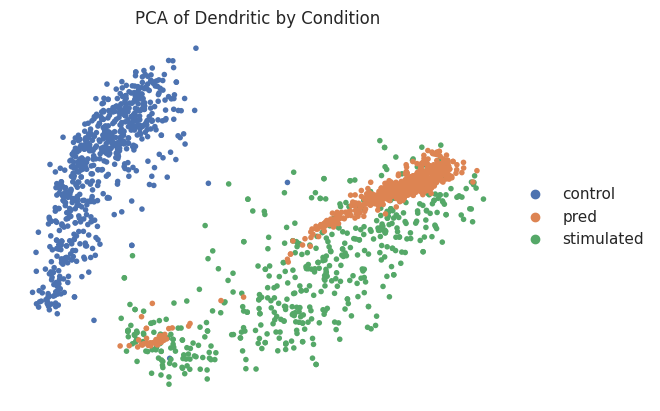

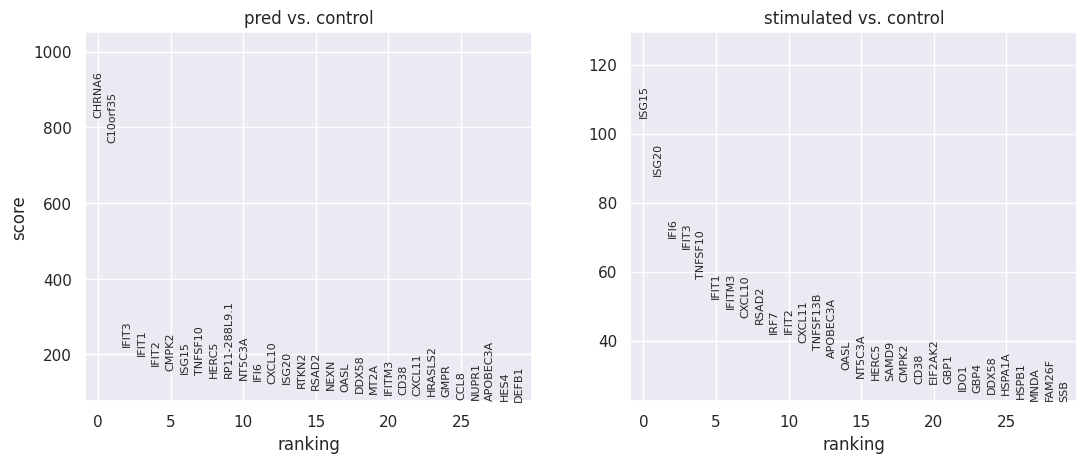

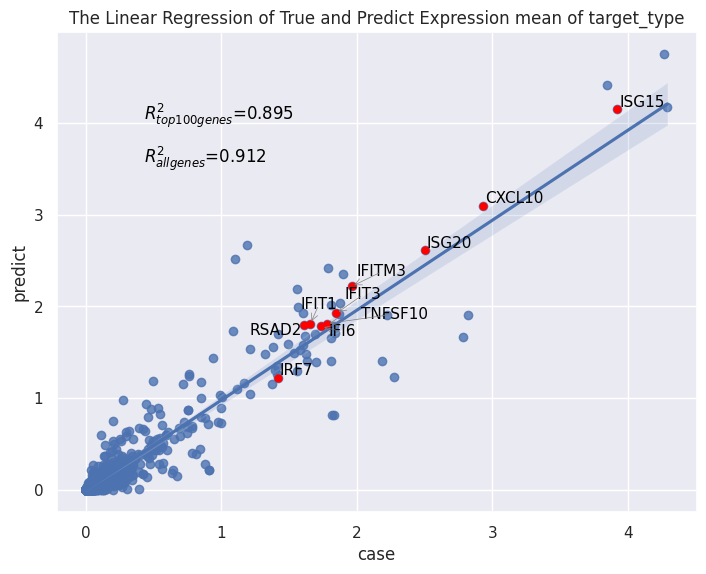

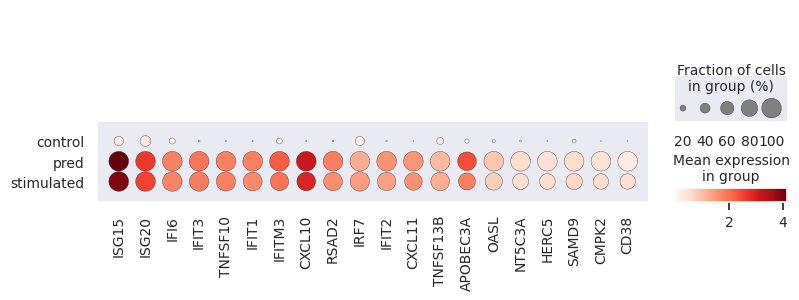

In [25]:
model.test(
    test_id_r = test_id_r,
    test_id_a = test_id_a, 
    model_path = None,
    load_model = False,
    output_path = None,
    test_pca = True,
    test_DEGs = True,
    test_R2 = True,
    test_dotplot = True,
    output_data = False,
    return_predict = False
)

In [26]:
cluster_index = pd.read_csv('cluster_index.csv', index_col=0)
cluster_index

,DEGs,r2mean,r2mean_top100,data_name
con2sti,68,0.912,0.895,Dendritic


[INFO] Tester: get predicting ...
[INFO] Tester: get predicting ...
stimulated to control predicting...: 100%|██████████████████████████| 17/17 [00:00<00:00, 33.71it/s]
[INFO] Tester: calculate neighbors graph for following test ...
[INFO] Tester: calculate neighbors graph for following test ...


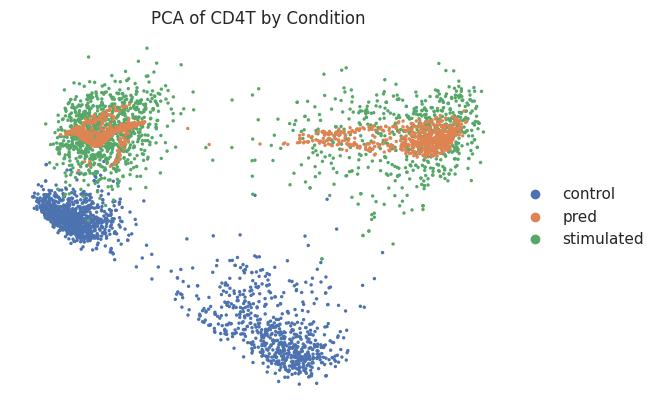

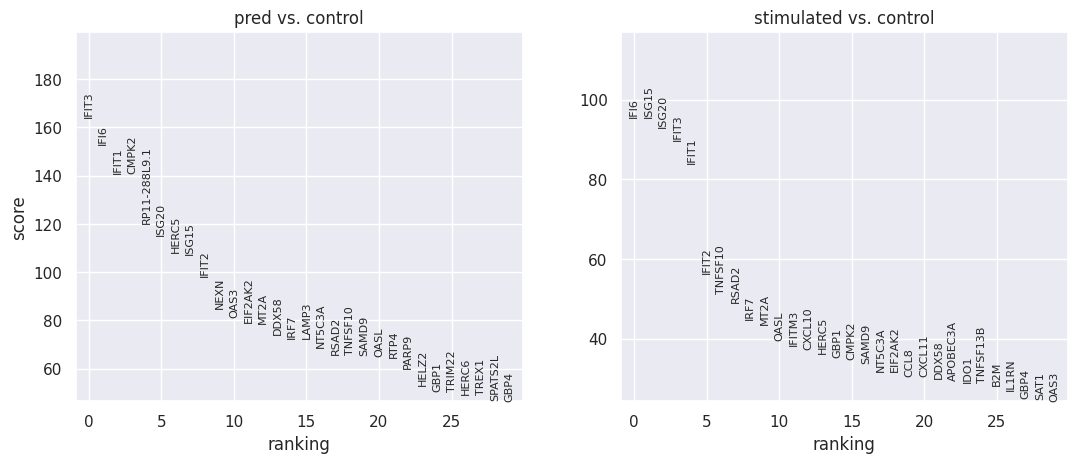

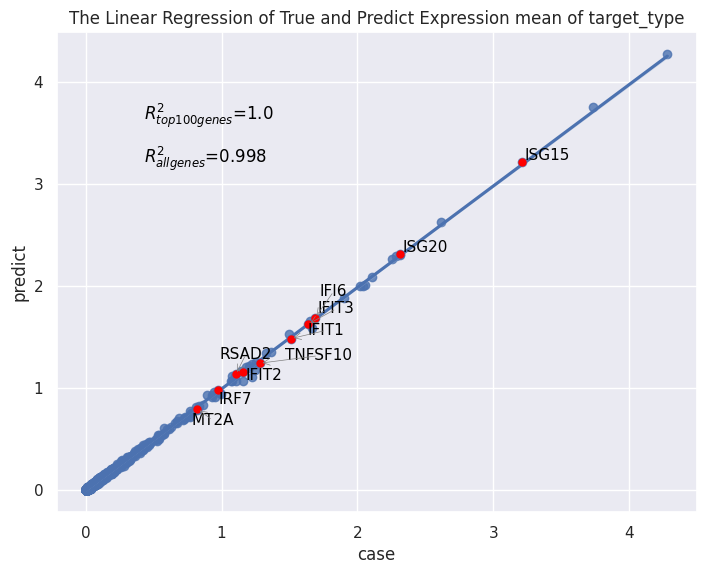

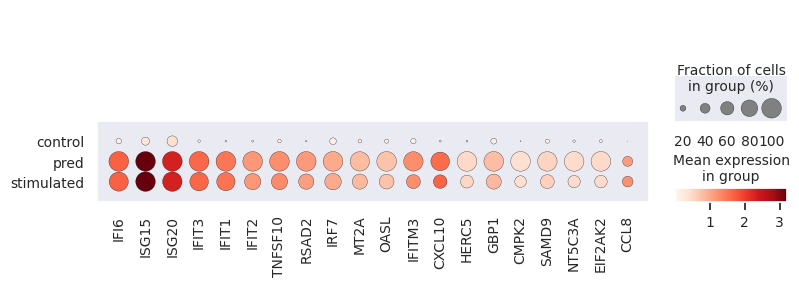

In [21]:
model.test(
    test_id_r = validation_id_r,
    test_id_a = validation_id_a, 
    model_path = None,
    load_model = False,
    output_path = None,
    test_pca = True,
    test_DEGs = True,
    test_R2 = True,
    test_dotplot = True,
    output_data = False,
    return_predict = False
)

[INFO] Tester: get predicting ...
[INFO] Tester: get predicting ...
[INFO] Tester: get predicting ...
stimulated to control predicting...: 100%|██████████████████████████| 67/67 [00:01<00:00, 50.93it/s]
[INFO] Tester: calculate neighbors graph for following test ...
[INFO] Tester: calculate neighbors graph for following test ...
[INFO] Tester: calculate neighbors graph for following test ...


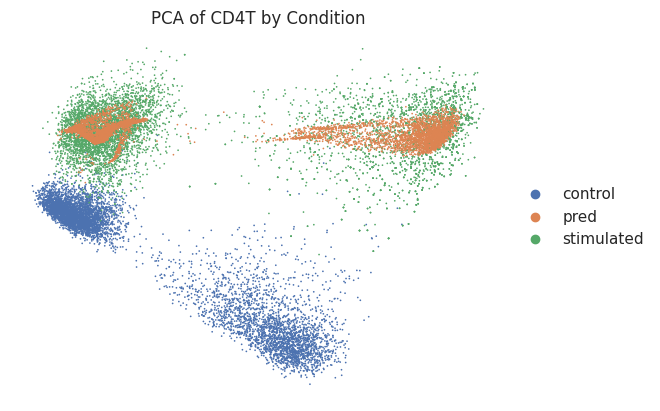

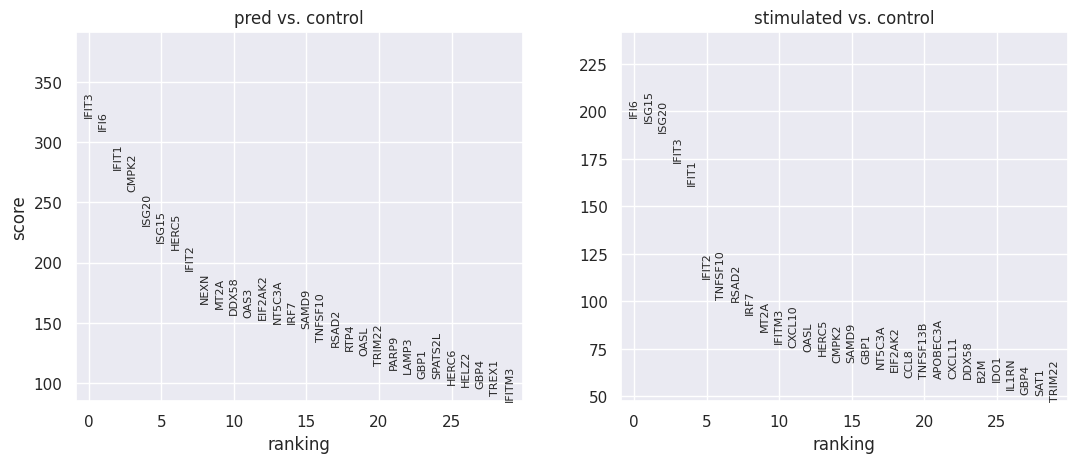

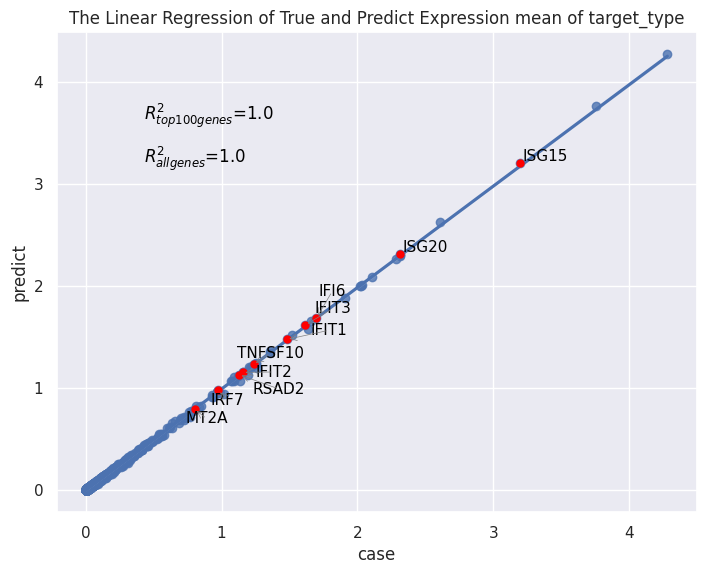

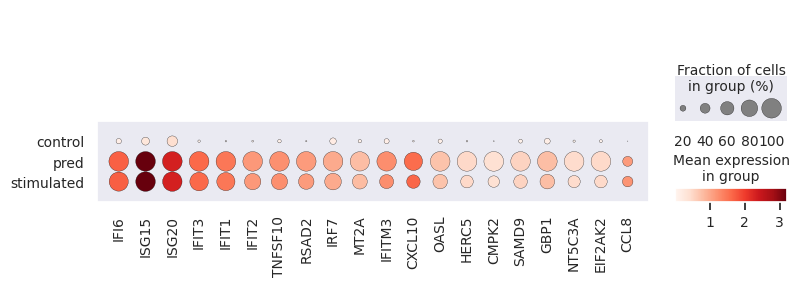

In [23]:
model.test(
    test_id_r = train_id_r,
    test_id_a = train_id_a, 
    model_path = None,
    load_model = False,
    output_path = None,
    test_pca = True,
    test_DEGs = True,
    test_R2 = True,
    test_dotplot = True,
    output_data = False,
    return_predict = False
)

Performance measures are automatically output to ``cluster_index.csv``.

In [24]:
cluster_index = pd.read_csv('cluster_index.csv', index_col=0)
cluster_index

,DEGs,r2mean,r2mean_top100,data_name
con2sti,85,1.0,1.0,CD4T
